#### Importing libraries and metadata

In [ ]:
import os
import pyodbc
import urllib
from dotenv import load_dotenv
from langchain import hub
from langchain.agents import create_sql_agent
from langchain.agents.agent_types import AgentType
from langchain_community.utilities.sql_database import SQLDatabas
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_openai import OpenAI, AzureChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage,AIMessage
from sqlalchemy import create_engine

from langgraph.prebuilt import create_react_agent

load_dotenv()

connection_string = os.environ["AZURE_SQL_CONNECTIONSTRING"]

SQL_SERVER_USERNAME = os.environ["SQL_SERVER_USERNAME"]
SQL_SERVER_ENDPOINT = os.environ["SQL_SERVER_ENDPOINT"]
SQL_SERVER_PASSWORD = os.environ["SQL_SERVER_PASSWORD"]
SQL_SERVER_DATABASE = os.environ["SQL_SERVER_DATABASE"] 
driver = "{ODBC Driver 18 for SQL Server}"
sqlalchemy_driver = "ODBC Driver 18 for SQL Server"


#### Instantiating connections

In [ ]:
## Azure OpenAI Client
aoai_client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
  api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
  api_version="2024-10-21"
)
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-4o", model_provider="azure_openai", api_version="2024-10-21")

    
## Creating connector for SQLAlchemy
sql_connection_string= f'DRIVER={driver};SERVER={SQL_SERVER_ENDPOINT};PORT=1433;DATABASE={SQL_SERVER_DATABASE};UID={SQL_SERVER_USERNAME};PWD={SQL_SERVER_PASSWORD};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
params = urllib.parse.quote_plus(sql_connection_string)
conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(params)

engine_azure = create_engine(conn_str,echo=True)
db = SQLDatabase(engine_azure, view_support=True, schema="dbo")

# test the connection
print(db.dialect)
print(db.get_usable_table_names())
db.run("select convert(varchar(25), getdate(), 120)")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

## Creatng a connection for pyodbc
conn = pyodbc.connect(f'DRIVER={driver};SERVER={SQL_SERVER_ENDPOINT};PORT=1433;DATABASE={SQL_SERVER_DATABASE};UID={SQL_SERVER_USERNAME};PWD={SQL_SERVER_PASSWORD}')  
cursor = conn.cursor()

2025-02-19 19:08:55,640 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2025-02-19 19:08:55,640 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-02-19 19:08:55,712 INFO sqlalchemy.engine.Engine SELECT schema_name()
2025-02-19 19:08:55,713 INFO sqlalchemy.engine.Engine [generated in 0.00077s] ()
2025-02-19 19:08:55,924 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2025-02-19 19:08:55,925 INFO sqlalchemy.engine.Engine [generated in 0.00081s] ()
2025-02-19 19:08:55,996 INFO sqlalchemy.engine.Engine SELECT 1 FROM fn_listextendedproperty(default, default, default, default, default, default, default)
2025-02-19 19:08:55,997 INFO sqlalchemy.engine.Engine [generated in 0.00078s] ()
2025-02-19 19:08:56,139 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-02-19 19:08:56,139 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES

In [63]:
toolkit.get_tools()

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002B6EF3BE270>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002B6EF3BE270>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002B6EF3BE270>),
 QuerySQLCheckerTool(description='Use this tool to 

In [ ]:
prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

c:\Users\jomedin\AppData\Local\anaconda3\envs\secdemo\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


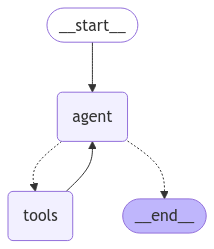

In [ ]:
system_message = prompt_template.format(dialect="Microsoft SQL Server Database", top_k=10)
agent_executor = create_react_agent(llm, tools, prompt=system_message)

from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [119]:
example_query = "Can you analyze the database give me all the insights that you could find? Please run a detailed analysis and find trends and patterns inside and across tables. Use statistics like correlation if you need to. Please be as detailed as possible. Please write and execute a detailed analysis plan. Please ignore taxi data"

events = agent_executor.stream(
    {"messages": [("user", example_query)]},
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you analyze the database give me all the insights that you could find? Please run a detailed analysis and find trends and patterns inside and across tables. Use statistics like correlation if you need to. Please be as detailed as possible. Please write and execute a detailed analysis plan. Please ignore taxi data
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_dxjWB3ChKZQU3mTbDHR9ykiQ)
 Call ID: call_dxjWB3ChKZQU3mTbDHR9ykiQ
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Customers, Merchants, Products, Sales, Sales_Detail, Stock, greenTaxiData, yellowTaxiData
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_6JO1umR4Npy44lX0Jpti4a39)
 Call ID: call_6JO1umR4Npy44lX0Jpti4a39
  Args:
    table_names: Cu

In [120]:
event["messages"][-1].pretty_print()

================================== Ai Message ==================================

### Insights from Temporal Sales and Stock Analysis:

#### **Sales Trends Over Time**
1. **Monthly Sales Count and Revenue**:
   - **Peak Revenue Month (2023)**: January saw the highest revenue ($2,040), coupled with 31 sales transactions.
   - Other strong revenue months include:
     - August ($2,006) and July ($1,995), reflecting mid-year peaks.
     - October also showed high performance ($1,990).
   - **Low Revenue and Sales**:
     - February recorded the lowest activity (8 sales and $405 total revenue).
   - **Seasonal Trends**:
     - Consistent high sales occur around the middle (July-August) and start (January) of the year.

#### **Stock Efficiency Analysis**
1. **Top-Selling Product & Stock Levels**:
   - **Surface Pen** dominates sales with 1,063,700 units sold.
   - Stock levels for Surface Pen across merchants vary widely:
     - Stock in different locations ranges from 30 to 495 units, pote

In [121]:
event

{'messages': [HumanMessage(content='Can you analyze the database give me all the insights that you could find? Please run a detailed analysis and find trends and patterns inside and across tables. Use statistics like correlation if you need to. Please be as detailed as possible. Please write and execute a detailed analysis plan. Please ignore taxi data', additional_kwargs={}, response_metadata={}, id='3b279fd8-b7d9-43f2-8905-b20c5d2e8f2d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dxjWB3ChKZQU3mTbDHR9ykiQ', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 605, 'total_tokens': 617, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fi

In [128]:
for message in event["messages"]:
    if isinstance(message, AIMessage):
        print(message.content)



To perform a detailed analysis of the database and extract trends and patterns, we'll handle it systematically, starting with analyzing data relationships within and across tables. Here's the analysis plan:

---

### **1. Analyze Customer Patterns**
   - **Goal:** Understand details related to customers such as their focus regions, links to their purchase habits, and the merchants they interact with.
   - Queries:
     - Count total customers.
     - Analyze customer purchase frequencies (links with the `Sales` table).
     - Relationship: Link `Customers` and `Merchants` through `Sales` to see which merchants attract the most customers.

---

### **2. Analyze Merchant Activities**
   - **Goal:** Assess merchant distribution and sales.
   - Queries:
     - Count total merchants and their regional distribution.
     - Analyze sales associated with each merchant using the `Sales` table.
     - Explore diversity of products they stock and sell, correlating with the `Stock` and `Products